# Simulation of a coherent optical homodyne (intradyne) transmission

This simulation emulates a single polarization coherent opitcal intradyne transmission inclouding ideal E/O and O/E conversion, laser phase noise and carrier frequency offset.

## Loading required packages

In [4]:
import numpy as np
import scipy.signal as ssignal
import matplotlib.pyplot as plt
import scipy.interpolate as sinterp
try:
    # if you installed skcomm with pypi
    import skcomm  as skc
except:
    # if you like to use skcomm directly from source.
    # Please note: If you want to import skcomm into your file using this snippet, you must ensure that the file is on a directional level below skcomm.
    import sys, os
    current_parent_folder = os.path.abspath('..')
    sys.path.append(os.path.join(current_parent_folder))
    import skcomm as skc

## Signal parameters

In [5]:
n_bits = 2**15
symbol_rate = 12.8e9
modulation_order = 4
roll_off = 0.1
dac_sr = 16e9 # sample rate of DAC
snr_set = 20
laser_linewidth = 1*100e3 # [Hz]
frequecy_offset = 100e6 # frequency offset


## Transmitter

In [6]:
sig_tx = skc.signal.Signal(n_dims=1)
sig_tx.symbol_rate = symbol_rate

tx_upsampling = dac_sr / sig_tx.symbol_rate[0]

# generate bits
sig_tx.generate_bits(n_bits=n_bits, seed=1)

# set constellation (modulation format)
sig_tx.generate_constellation(format='QAM', order=modulation_order)

# create symbols
sig_tx.mapper()

# upsampling and pulseshaping
sig_tx.pulseshaper(upsampling=tx_upsampling, pulseshape='rrc', roll_off=[roll_off])

# format samples so that driver can handle them (range +-1)
maxVal = np.max(np.abs(np.concatenate((np.real(sig_tx.samples), np.imag(sig_tx.samples)))))
samples = np.asarray(sig_tx.samples) / maxVal
samples = np.concatenate((np.real(samples), np.imag(samples)))

## Channel

In [7]:
# build ideal complex signal from Tx samples (no ampl. and phase noise)
samples = samples[0] + 1j*samples[1] 

sps = sig_tx.sample_rate[0] / sig_tx.symbol_rate[0]

# get samples from scope (repeat rx sequence)
ext = 40000*sps + 4000*sps
ratio_base = int(ext // samples.size)
ratio_rem = int(ext % samples.size        )
samples = np.concatenate((np.tile(samples, ratio_base), samples[:ratio_rem]), axis=0)

# add amplitude noise
samples = skc.channel.set_snr(samples, snr_dB=snr_set, sps=sig_tx.sample_rate[0]/sig_tx.symbol_rate[0], seed=None)

# add frequency offset
samples = skc.channel.add_frequency_offset(samples,
                                            sample_rate=sig_tx.sample_rate[0], 
                                            f_offset=frequecy_offset)

# phase noise emulation
samples = skc.channel.add_phase_noise(samples ,sig_tx.sample_rate[0] , laser_linewidth, seed=1)['samples']
sr = sig_tx.sample_rate[0]

# add artificial sample clock error
ratio = 1.0 # ratio of sampling frequency missmatch     
n_old = np.size(samples, axis=0)
t_old = np.arange(n_old) / sr
n_new = int(np.round(ratio * n_old))
t_new = np.linspace(start=t_old[0], stop=t_old[-1], num=n_new, endpoint=True)
sr_new = 1 / (t_new[1] - t_new[0])
# interpolate signal at different timing / sampling instants
f = sinterp.interp1d(t_old, samples, kind='cubic')
samples = f(t_new)    

## Receiver

Resampling

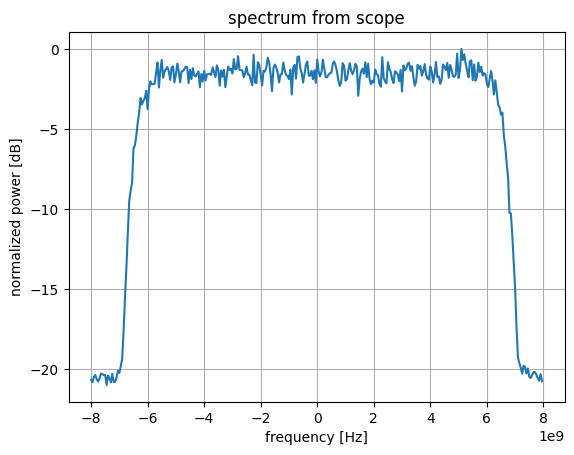

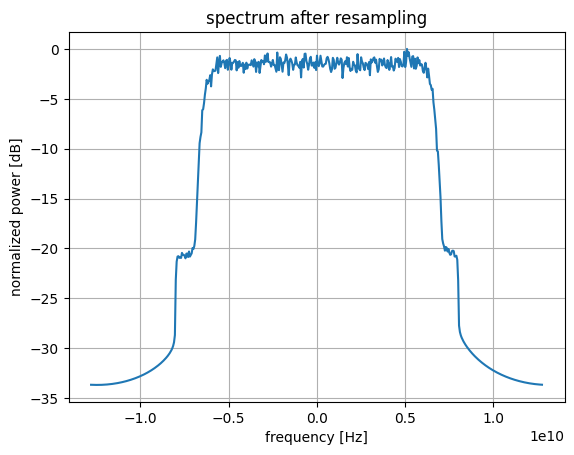

In [8]:
# contruct rx signal structure
sig_rx = sig_tx.copy()
sig_rx.samples = samples
sig_rx.sample_rate = sr

_ = sig_rx.plot_spectrum(tit='spectrum from scope',fNum=1,resolution_bw=50e6)

# From here: "standard" coherent complex baseband signal processing ############
# resample to 2 sps
sps_new = 2
sps = sig_rx.sample_rate[0]/sig_rx.symbol_rate[0]
new_length = int(sig_rx.samples[0].size/sps*sps_new)
sig_rx.samples = ssignal.resample(sig_rx.samples[0], new_length, window='boxcar')
sig_rx.sample_rate = sps_new*sig_rx.symbol_rate[0]

_ = sig_rx.plot_spectrum(tit='spectrum after resampling',fNum=2, resolution_bw=50e6)

SNR estimation

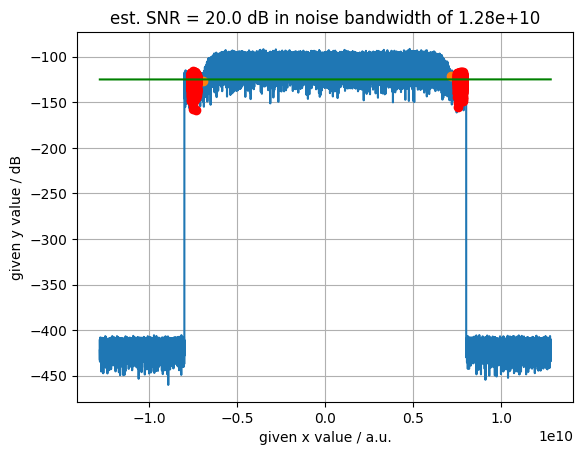

est. SNR (from spectrum): 20.0 dB


In [9]:
# estimate SNR
sig_range = np.asarray([-1, 1])*sig_rx.symbol_rate[0]/2*(1+roll_off) + frequecy_offset
noise_range = np.asarray([-1.1, -1.05, 1.05, 1.1]) * sig_rx.symbol_rate[0]/2 * (1+roll_off) + frequecy_offset

fft_temp = np.fft.fft(sig_rx.samples[0])/sig_rx.samples[0].size
RBW = sig_rx.sample_rate[0]/sig_rx.samples[0].size
spec = (np.abs(np.fft.fftshift(fft_temp))**2)/RBW # -> [W/Hz]
freq = np.fft.fftshift(np.fft.fftfreq(sig_rx.samples[0].size, 1/sig_rx.sample_rate[0]))
snr = skc.utils.estimate_snr_spectrum(freq, spec, sig_range=sig_range, 
                                       noise_range=noise_range, order=1, 
                                       noise_bw=sig_rx.symbol_rate[0], 
                                       scaling='lin', plotting=True, fNum=3)["snr_dB"]

print('est. SNR (from spectrum): {:.1f} dB'.format(snr))


Carrier frequency offset estimation and correction

In [11]:


# frequency offset estimation / correction
results_foe = skc.rx.frequency_offset_correction(sig_rx.samples[0], 
                                                  sample_rate=sig_rx.sample_rate[0],
                                                  symbol_rate=sig_rx.symbol_rate[0])

sig_rx.samples[0] = results_foe['samples_corrected']
print('estimated frequency offset: {:.0f} MHz'.format(results_foe['estimated_fo']/1e6))



estimated frequency offset: -0 MHz


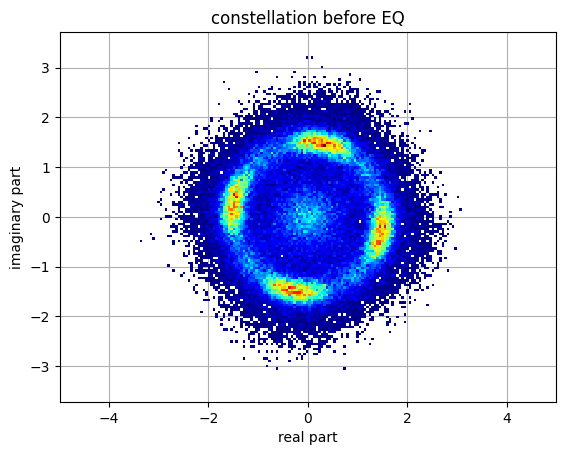

In [12]:

# normalize samples to mean magnitude of original constellation
mag_const = np.mean(abs(sig_rx.constellation[0]))
mag_samples= np.mean(abs(sig_rx.samples[0]))
sig_rx.samples = sig_rx.samples[0] * mag_const / mag_samples

sig_rx.plot_constellation(hist=True, tit='constellation before EQ', fNum=4)


Equalizer or matched filter

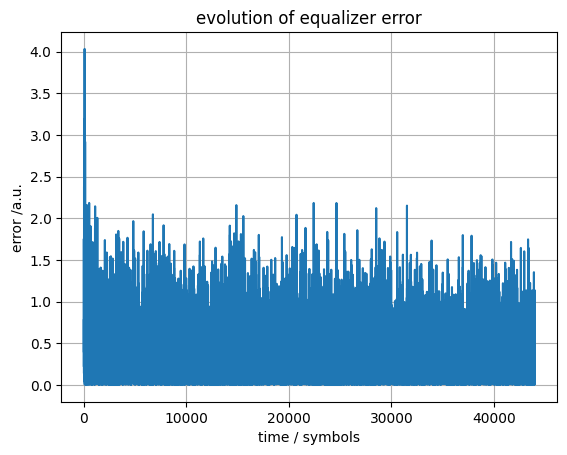

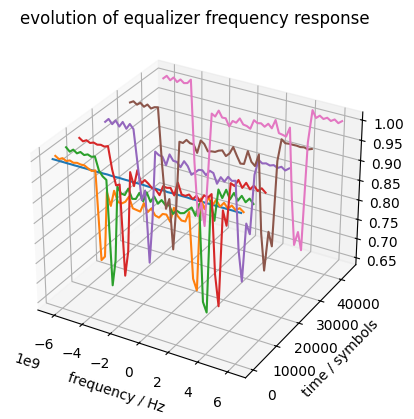

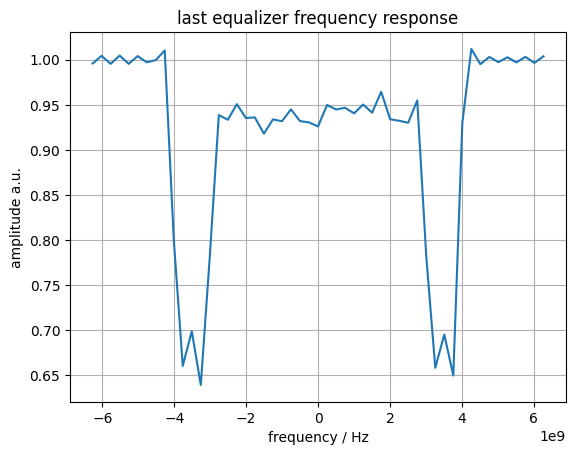

In [13]:

adaptive_filter = True
# either blind adaptive filter....
if adaptive_filter is True:    
    results = skc.rx.blind_adaptive_equalizer(sig_rx, n_taps=51, mu_cma=1e-4, 
                                               mu_rde=1e-5, mu_dde=0.5, decimate=True, 
                                               return_info=True, stop_adapting=-1, 
                                               start_rde=5000*0, start_dde=5000*0,
                                               exec_mode='auto')
    
    sig_rx = results['sig']
    h = results['h'][0]
    eps = results['eps'][0]
    # plot error evolution
    f = plt.figure(5)
    f.clear()
    plt.plot(np.abs(eps))
    plt.title('evolution of equalizer error')
    plt.xlabel('time / symbols')
    plt.ylabel('error /a.u.')
    plt.grid(visible=True)
    plt.show()       
    # plot evolution of filters frequency response
    f = plt.figure(6)
    f.clear()
    ax = plt.subplot(projection='3d')
    f = np.fft.fftshift(np.fft.fftfreq(h[0,:].size, d=1/sig_rx.sample_rate[0]))
    outsymbs = [0, 1000, 5000, 10000, 20000, 30000, h[:,0].size-1]    
    for outsymb in outsymbs:
        plt.plot(f, np.ones(f.size)*outsymb, np.abs(np.fft.fftshift(np.fft.fft(h[int(outsymb),:]))))
    plt.title('evolution of equalizer frequency response')
    plt.xlabel('frequency / Hz')
    plt.ylabel('time / symbols')  
    plt.grid(visible=True)
    plt.show()
     # plot last filter frequency response
    f = plt.figure(7)
    f.clear()
    f = np.fft.fftshift(np.fft.fftfreq(h[0,:].size, d=1/sig_rx.sample_rate[0]))
    plt.plot(f, np.abs(np.fft.fftshift(np.fft.fft(h[-1,:]))))
    plt.title('last equalizer frequency response')
    plt.xlabel('frequency / Hz')
    plt.ylabel('amplitude a.u.')
    plt.grid(visible=True)
    plt.show()               
        
    # cut away init symbols
    sps = int(sig_rx.sample_rate[0]/sig_rx.symbol_rate[0])
    cut = 10000
    sig_rx.samples = sig_rx.samples[0][int(cut)*sps:]

# ... or matched filtering
else:
    # Rx matched filter
    sig_rx.raised_cosine_filter(roll_off=roll_off,root_raised=True) 
    
    # crop samples here, if necessary
    sps = int(sig_rx.sample_rate[0] / sig_rx.symbol_rate[0])
    crop = 10*sps
    if crop != 0:
        sig_rx.samples = sig_rx.samples[0][crop:-crop]
    else:
        sig_rx.samples = sig_rx.samples[0]
    
    # sampling phase / clock adjustment
    block_size = -1 # size of one block in SYMBOLS... -1 for only one block
    sig_rx.sampling_clock_adjustment(block_size)
    


Decimation

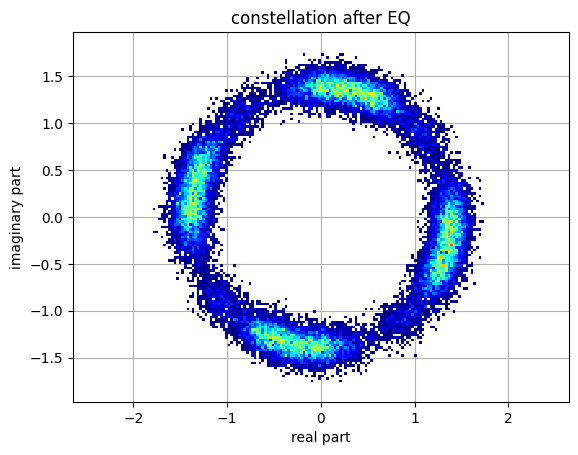

In [14]:
# sampling (if necessary)
START_SAMPLE = 0
sps = sig_rx.sample_rate[0] / sig_rx.symbol_rate[0] # CHECK FOR INTEGER SPS!!!
sig_rx.samples = sig_rx.samples[0][START_SAMPLE::int(sps)]
sig_rx.plot_constellation(0, hist=True, tit='constellation after EQ',fNum=8)


Carrier phase estimation / recovery

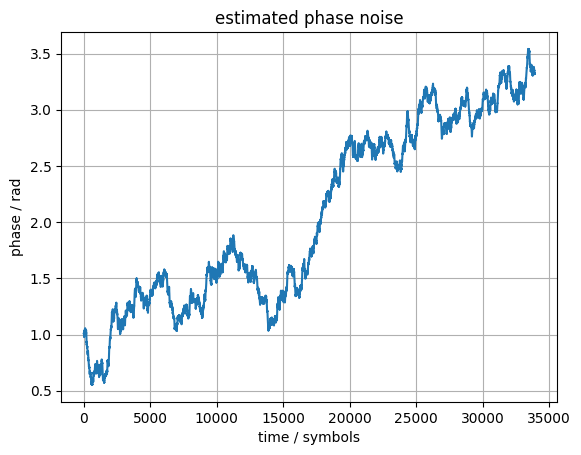

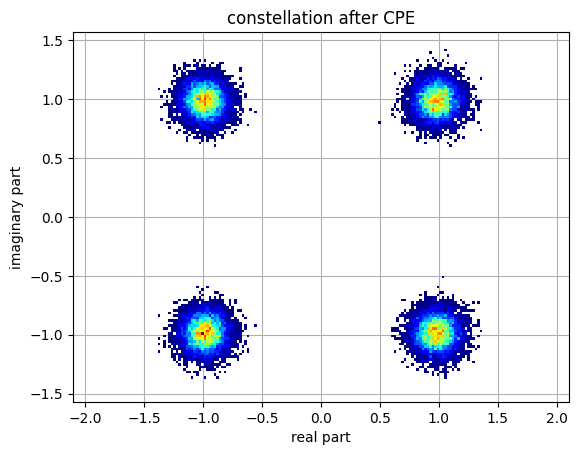

In [15]:

# CPE
viterbi = True
# ...either VV
if viterbi:
    cpe_results = skc.rx.carrier_phase_estimation_VV(sig_rx.samples[0], n_taps=31, 
                                                      filter_shape='wiener', mth_power=4, 
                                                      rho=.001)
    sig_rx.samples = cpe_results['rec_symbols']
    est_phase = cpe_results['phi_est'].real
# ...or BPS
else:
    cpe_results = skc.rx.carrier_phase_estimation_bps(sig_rx.samples[0], sig_rx.constellation[0], 
                                               n_taps=15, n_test_phases=45, const_symmetry=np.pi/2,
                                               exec_mode='auto')
    sig_rx.samples = cpe_results['samples_corrected']
    est_phase = cpe_results['est_phase_noise']

f = plt.figure(9)
f.clear()
plt.plot(est_phase)
plt.title('estimated phase noise')
plt.xlabel('time / symbols')
plt.ylabel('phase / rad')
plt.grid(visible=True)
plt.show()

sig_rx.plot_constellation(hist=True, tit='constellation after CPE',fNum=10)


Synchronizatin and quality metric estimation

In [16]:

# delay and phase ambiguity estimation and compensation
sig_rx = skc.rx.symbol_sequence_sync(sig_rx, dimension=-1)["sig"]
    
# calc EVM
evm = skc.utils.calc_evm(sig_rx, norm='max')
print("EVM: {:2.2%}".format(evm[0]))

# estimate SNR
snr = skc.utils.estimate_SNR_evm(sig_rx, norm='rms', method='data_aided', opt=False)
print("real SNR: {:.2f} dB, est. SNR (from EVM): {:.2f} dB".format(snr_set, snr[0]))

# decision and demapper
sig_rx.decision()
sig_rx.demapper()

# BER counting
ber_res = skc.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])
print('BER = {:.2e}'.format(ber_res['ber']))


EVM: 10.67%
real SNR: 20.00 dB, est. SNR (from EVM): 19.44 dB
BER = 0.00e+00
